In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from imbens.ensemble import SelfPacedEnsembleClassifier as SPEClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset

path_to_data = '../data/creditcard/creditcard.csv'

# col names data set
col_names = [
    "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","label"
] # V1-V28 are PCA transformed features, but are anonymized due to confidentiality reasons and are not interpretable
# Label is 1 if fraud, 0 otherwise

# read full data set
data = pd.read_csv(path_to_data, names=col_names, index_col=0, header=0)

# drop duplicates  & time column
data.drop_duplicates(inplace=True)
data.drop("Time", axis=1, inplace=True)

# Displaying the first 5 rows of the dataset
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,label
1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

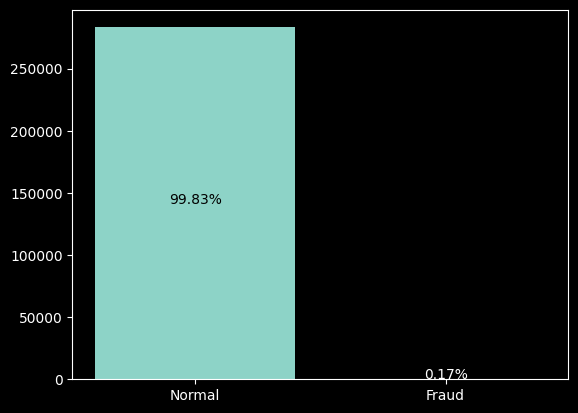

label
0    283253
1       473
Name: count, dtype: int64

In [4]:
# Visualize class imbalance
plt.bar(["Normal", "Fraud"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='white')

plt.show()

data.label.value_counts()

In [5]:
"""
Partition Dataset:
We stratify the split to ensure that the class distribution is preserved in the partitions.
"""

# First 80/20 split on original data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then 50/50 split on test data for validation and test set.
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [6]:
# Random search parameter space, prefix parameters with 'xgb__'
search_space_random_tuned = {
    'xgb__objective': ['binary:logistic'],
    'xgb__max_leaves': [0, 2**6, 2**8],
    'xgb__learning_rate': [0.002, 0.1, 0.3],
    'xgb__gamma': [0.1, 0.3],
    'xgb__max_depth': [6, 12, 20, 25],
    'xgb__subsample': [0.4, 0.7, 1],
    'xgb__colsample_bytree': [0.4, 0.5, 0.7, 1],
    'xgb__reg_alpha': [0, 0.9, 1],
    'xgb__reg_lambda': [0.3, 1],
    'xgb__scale_pos_weight': [1, 2, 4, 580],
    'xgb__eval_metric': ['auc'],
    'xgb__n_estimators': [100, 170, 500, 700, 1000, 2000, 5000],
    'xgb__booster': ['gbtree'],
    'xgb__tree_method': ['hist'],
}

# Vanilla XGBoost
vanilla_xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier())  # Default XGBoost classifier
])

# RandomizedSearchCV XGBoost
random_search_xgb = Pipeline([
    ('xgb', XGBClassifier())
])

# 10-fold cross-validation setup
cv = StratifiedKFold(n_splits=10)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=random_search_xgb,
    param_distributions=search_space_random_tuned,
    n_iter=10,
    scoring='f1',  # Use F1-score to handle imbalanced classes
    cv=cv, # 10-fold stratified cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run random search on XGBoost and fit to training data
print("Running RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train)

# Best parameters from random search
best_params = random_search.best_params_
print(f"Best parameters from RandomizedSearchCV: {best_params}")

# Best estimator from RandomizedSearchCV
best_xgb_model = random_search.best_estimator_


spe_boosted_xgb_pipeline = Pipeline([
    ('spe_xgb', SPEClassifier())  # Self-paced ensemble classifier with XGBoost as base learner
])

models = [
    ('Vanilla XGBoost', vanilla_xgb_pipeline),
    ('RandomizedSearchCV XGBoost', best_xgb_model),
    ('SPE-Boosted XGBoost', spe_boosted_xgb_pipeline)
]

# Define custom scoring methods
scoring_metrics = {
    'precision': make_scorer(precision_score, average='binahowry'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# Evaluation loop
for model_name, model in models:
    print('-----------------------------------------------------')
    print(f"\nEvaluating {model_name}...")

    # Perform cross-validation for each scoring metric
    precision_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=scoring_metrics['precision'])
    print(f"Precision scores: {precision_scores}")
    recall_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=scoring_metrics['recall'])
    print(f"Recall scores: {recall_scores}")
    f1_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=scoring_metrics['f1'])
    print(f"F1 scores: {f1_scores}")

    # Calculate mean and standard deviation for each metric
    precision_mean, precision_std = np.mean(precision_scores), np.std(precision_scores)
    recall_mean, recall_std = np.mean(recall_scores), np.std(recall_scores)
    f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)

    # Print cross-validation results
    print(f"\nCross-Validation Results for {model_name}:")
    print(f"Precision: {precision_mean:.4f} ± {precision_std:.4f}")
    print(f"Recall: {recall_mean:.4f} ± {recall_std:.4f}")
    print(f"F1-Score: {f1_mean:.4f} ± {f1_std:.4f}")

    # Fit the model on the full training data
    model.fit(X_train, y_train)
    
    # Test set evaluation
    y_pred = model.predict(X_test)
    print(f"\nTest Set Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

Running RandomizedSearchCV for XGBoost...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters from RandomizedSearchCV: {'xgb__tree_method': 'hist', 'xgb__subsample': 0.4, 'xgb__scale_pos_weight': 580, 'xgb__reg_lambda': 0.3, 'xgb__reg_alpha': 0.9, 'xgb__objective': 'binary:logistic', 'xgb__n_estimators': 700, 'xgb__max_leaves': 256, 'xgb__max_depth': 20, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__eval_metric': 'auc', 'xgb__colsample_bytree': 1, 'xgb__booster': 'gbtree'}
-----------------------------------------------------

Evaluating Vanilla XGBoost...
Precision scores: [nan nan nan nan nan nan nan nan nan nan]
Recall scores: [0.72972973 0.78378378 0.73684211 0.78947368 0.81578947 0.84210526
 0.89473684 0.71052632 0.86842105 0.86842105]
F1 scores: [0.81818182 0.85294118 0.82352941 0.84507042 0.88571429 0.91428571
 0.91891892 0.81818182 0.91666667 0.90410959]

Cross-Validation Results for Vanilla XGBoost:
Precision: nan ± nan
Recall: 0.8040 ± 0.0612
